In [1]:
!pip install -q torch_snippets
from torch_snippets import *
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import make_grid
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataset = datasets.MNIST(root='MNIST/', train=True, \
 transform=transforms.ToTensor(), \
 download=True)
test_dataset = datasets.MNIST(root='MNIST/', train=False, \
 transform=transforms.ToTensor(), \
 download=True)
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, \
 batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset= test_dataset, \
 batch_size=64, shuffle=False)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.5/108.5 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.7/83.7 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.6/220.6 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.7/162.7 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 65.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 kB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 57.9 MB/s eta 0:00:00
Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.1MB/s]


Extracting MNIST/MNIST/raw/train-images-idx3-ubyte.gz to MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 481kB/s]


Extracting MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.45MB/s]


Extracting MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 9.82MB/s]

Extracting MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/MNIST/raw



### How does VAE Works?
1) The output of the encoder is two vectors:
- Mean vector
- Standard Deviation

2) We sum the two vectors(mean and variation) which is mutliplied by small random number. The dimensions of the resultant vector will same to that of each vectors.

3) The resultant vector is passed to the decoder to fetch the images.

4) Loss value optimization is combination of:
- KL Divergence loss: measures the deviation of distribution of mean vector and standard variance vector from 0 and 1 resp.
-  MSE: optimization we use to reconstruct the image.

In [7]:
class VAE(nn.Module):
  def __init__(self, x_dim, h_dim1, h_dim2, latent_dim):
    super(VAE, self).__init__()
    #encoder section:
    self.d1=nn.Linear(x_dim, h_dim1) #input -> hidden layer 1
    self.d2=nn.Linear(h_dim1, h_dim2) #hidden layer 1 -> hidden layer 2

    # mean and standard variation vectors:
    self.d31=nn.Linear(h_dim2, latent_dim) # hidden layer 2 -> Mean
    self.d32=nn.Linear(h_dim2, latent_dim) # hidden layer 2 -> log variance

    #decoder section:
    self.d4=nn.Linear(latent_dim, h_dim2) # latent -> hidden layer 2
    self.d5=nn.Linear(h_dim2, h_dim1) #hidden layer 2 -> hidden layer 1
    self.d6=nn.Linear(h_dim1, x_dim)

  def encoder(self, x):
    h=F.relu(self.d1(x))
    h=F.relu(self.d2(h))
    return self.d31(h), self.d32(h) # d31:vector for mean, d32:vector for log variance

  def sampling(self, mean, log_var):
    std=torch.exp(log_var * 0.5) #standard deviation
    eps=torch.randn_like(std) # small random number
    return eps.mul(std).add_(mean) # addition of mean ans std

  def decoder(self, x):
    h=F.relu(self.d4(x))
    h=F.relu(self.d5(h))
    return F.sigmoid(self.d6(h))

  def forward(self, x):
    mean, log_var= self.encoder(x.view(-1, 784))
    z=self.sampling(mean, log_var)
    return self.decoder(z), mean, log_var

In [11]:
def train_batch(data, model, optimizer, loss_function):
  model.train()
  data=data.to(device)
  optimizer.zero_grad()
  reconstruct_batch, mean, log_var= model(data)
  loss, mse, kld=loss_function(reconstruct_batch, data, mean, log_var)
  loss.backward()
  optimizer.step()
  return loss, mse, kld, log_var.mean(), mean.mean()

@torch.no_grad()
def validate_batch(data, model, loss_function):
  model.eval()
  data=data.to(device)
  reconstruct, mean, log_var=model(data)
  loss, mse, kld=loss_function(reconstruct, data, mean, log_var)
  return loss, mse, kld, log_var.mean(), mean.mean()

def loss_function(recon_x, x, mean, log_var):
  RECON=F.mse_loss(recon_x, x.view(-1, 784), reduction='sum')
  KLD= -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
  return RECON + KLD, RECON, KLD


In [12]:
vae=VAE(x_dim=784, h_dim1=512, h_dim2=256, latent_dim=50).to(device)
optimizer=optim.AdamW(vae.parameters(), lr=1e-3)

Epoch 1, Step 938/938, Train Loss: 1217.4180, KLD: 208.0586
Epoch 1 Avg Train Loss: 2963.6085
Epoch 1, Step 157/157, Val Loss: 617.2277, KLD: 121.3559
Epoch 1 Avg Val Loss: 2426.5649


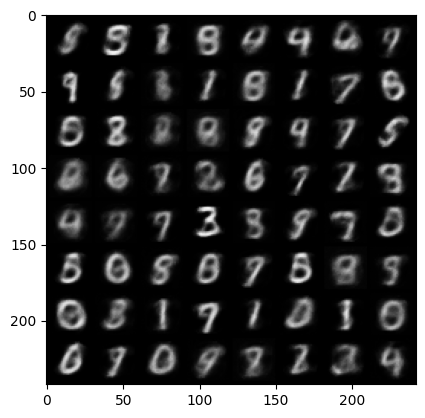

Epoch 2, Step 938/938, Train Loss: 1092.8997, KLD: 259.3243
Epoch 2 Avg Train Loss: 2257.3445
Epoch 2, Step 157/157, Val Loss: 521.8473, KLD: 142.4830
Epoch 2 Avg Val Loss: 2108.8313


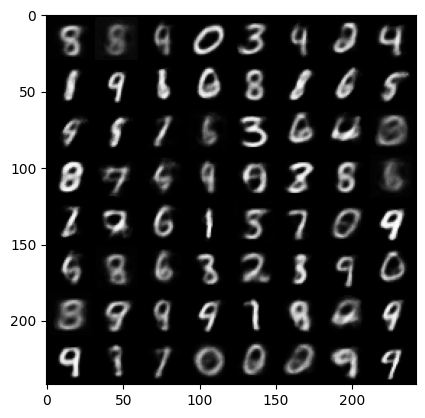

Epoch 3, Step 938/938, Train Loss: 880.8361, KLD: 275.6671
Epoch 3 Avg Train Loss: 2073.1608
Epoch 3, Step 157/157, Val Loss: 484.8828, KLD: 154.6004
Epoch 3 Avg Val Loss: 2013.6667


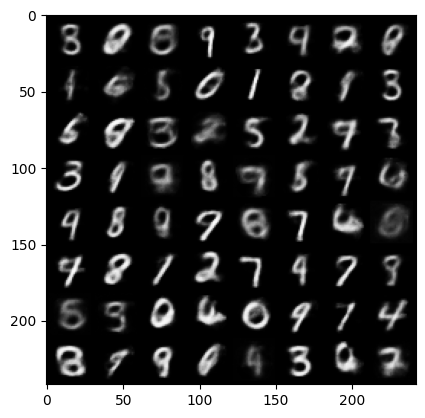

Epoch 4, Step 938/938, Train Loss: 1040.6377, KLD: 282.6170
Epoch 4 Avg Train Loss: 1999.2583
Epoch 4, Step 157/157, Val Loss: 503.0674, KLD: 152.4048
Epoch 4 Avg Val Loss: 1968.3331


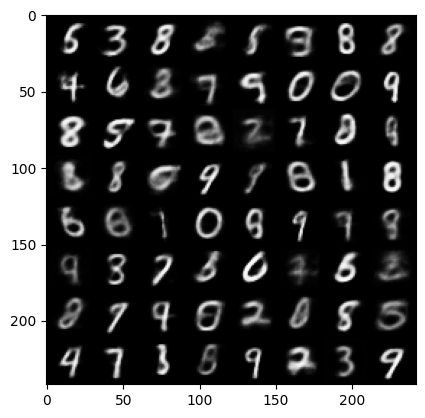

Epoch 5, Step 938/938, Train Loss: 1029.3228, KLD: 309.7515
Epoch 5 Avg Train Loss: 1957.9216
Epoch 5, Step 157/157, Val Loss: 479.8092, KLD: 164.7734
Epoch 5 Avg Val Loss: 1923.3432


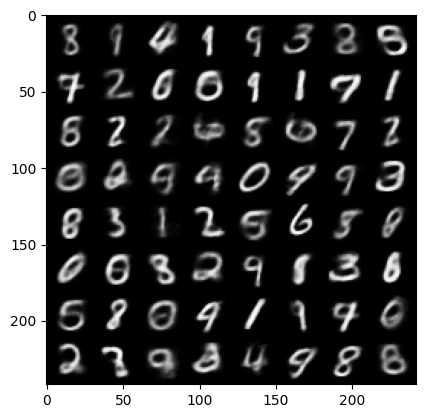

Epoch 6, Step 938/938, Train Loss: 1044.9133, KLD: 297.6005
Epoch 6 Avg Train Loss: 1926.5281
Epoch 6, Step 157/157, Val Loss: 465.9733, KLD: 163.6673
Epoch 6 Avg Val Loss: 1897.3659


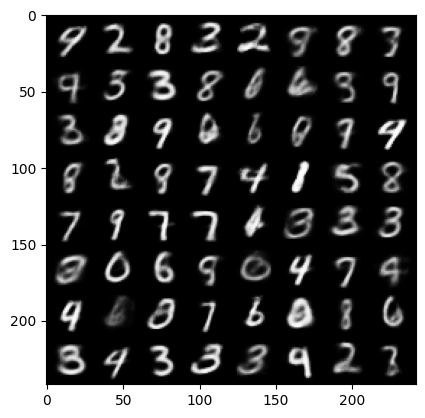

Epoch 7, Step 938/938, Train Loss: 978.2166, KLD: 300.7287
Epoch 7 Avg Train Loss: 1906.1173
Epoch 7, Step 157/157, Val Loss: 438.3990, KLD: 166.8751
Epoch 7 Avg Val Loss: 1881.1965


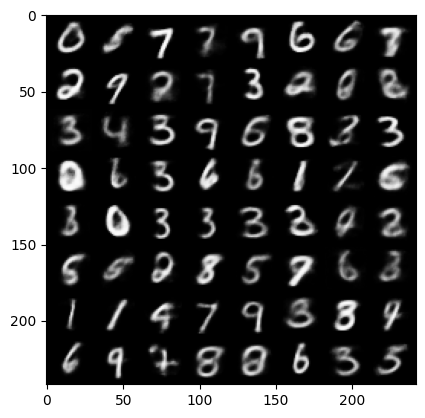

Epoch 8, Step 938/938, Train Loss: 948.2494, KLD: 309.0791
Epoch 8 Avg Train Loss: 1885.8597
Epoch 8, Step 157/157, Val Loss: 451.1075, KLD: 167.3566
Epoch 8 Avg Val Loss: 1867.0168


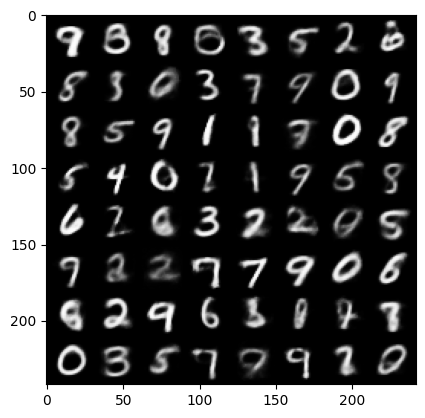

Epoch 9, Step 938/938, Train Loss: 995.3267, KLD: 320.2721
Epoch 9 Avg Train Loss: 1872.2755
Epoch 9, Step 157/157, Val Loss: 446.9059, KLD: 171.8347
Epoch 9 Avg Val Loss: 1857.5694


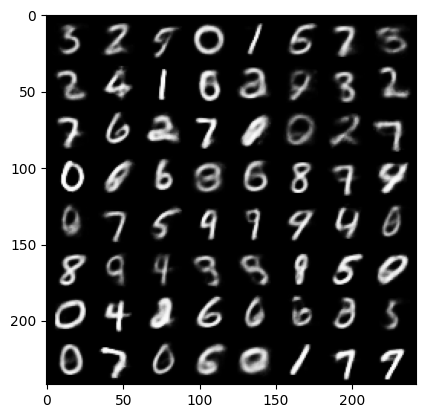

Epoch 10, Step 938/938, Train Loss: 896.7445, KLD: 308.5905
Epoch 10 Avg Train Loss: 1860.3850
Epoch 10, Step 157/157, Val Loss: 428.0598, KLD: 167.2601
Epoch 10 Avg Val Loss: 1853.1194


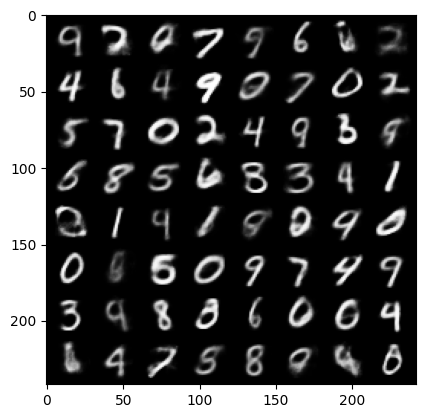

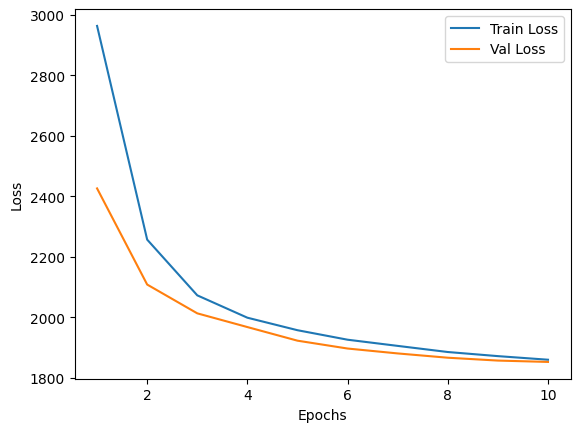

In [13]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

n_epochs = 10
train_losses, val_losses = [], []

for epoch in range(n_epochs):
    train_loss_total, val_loss_total = 0, 0
    N = len(train_loader)

    for batch_idx, (data, _) in enumerate(train_loader):
        loss, recon, kld, log_var, mean = train_batch(data, vae, optimizer, loss_function)
        train_loss_total += loss.item()

        pos = epoch + (1 + batch_idx) / N
        print(f"Epoch {epoch+1}, Step {batch_idx+1}/{N}, Train Loss: {loss.item():.4f}, KLD: {kld.item():.4f}", end='\r')

    train_losses.append(train_loss_total / N)
    print(f"\nEpoch {epoch+1} Avg Train Loss: {train_losses[-1]:.4f}")

    N = len(test_loader)
    for batch_idx, (data, _) in enumerate(test_loader):
        loss, recon, kld, log_var, mean = validate_batch(data, vae, loss_function)
        val_loss_total += loss.item()

        pos = epoch + (1 + batch_idx) / N
        print(f"Epoch {epoch+1}, Step {batch_idx+1}/{N}, Val Loss: {loss.item():.4f}, KLD: {kld.item():.4f}", end='\r')

    val_losses.append(val_loss_total / N)
    print(f"\nEpoch {epoch+1} Avg Val Loss: {val_losses[-1]:.4f}")

    with torch.no_grad():
        z = torch.randn(64, 50).to(device)
        sample = vae.decoder(z).to(device)
        images = make_grid(sample.view(64, 1, 28, 28)).permute(1, 2, 0)
        plt.imshow(images.cpu().numpy())
        plt.show()

plt.plot(range(1, n_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, n_epochs + 1), val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

